In [53]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from load_data import *
from util import *
import copy
import gc
import time
import math
np.random.seed(43)

In [54]:
batch_size = 128
epochs = 70
acquired_points = 10
num_classes = 10
acquisition_times = 100
data_variances = [0.05, 0.02, 0.01, 0.1, 0.005]
device = torch.device("mps") if torch.mps.is_available() else "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else device
x_train_new, y_train_new, X_p, y_p, x_val, y_val, x_test, y_test = load_mnist()
x_train_new = x_train_new.to(dtype=torch.float32).to(device)
y_train_new = y_train_new.to(dtype=torch.float32).to(device)
X_p = X_p.to(dtype=torch.float32)
y_p = y_p.to(dtype=torch.float32)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)

x_train shape: torch.Size([60000, 1, 28, 28])
60000 train samples, before reduction
10000 test samples
(tensor([    1,    21,    34,  ..., 59952, 59972, 59987]),)
(tensor([    3,     6,     8,  ..., 59979, 59984, 59994]),)
(tensor([    5,    16,    25,  ..., 59983, 59985, 59991]),)
(tensor([    7,    10,    12,  ..., 59978, 59980, 59996]),)
(tensor([    2,     9,    20,  ..., 59943, 59951, 59975]),)
(tensor([    0,    11,    35,  ..., 59968, 59993, 59997]),)
(tensor([   13,    18,    32,  ..., 59982, 59986, 59998]),)
(tensor([   15,    29,    38,  ..., 59963, 59977, 59988]),)
(tensor([   17,    31,    41,  ..., 59989, 59995, 59999]),)
(tensor([    4,    19,    22,  ..., 59973, 59990, 59992]),)


# VI utils

In [55]:
#This is actually treated as the std
weights_prior_std = 0.01
# This implies that the covariance matrix of each W_i is diag(weights_prior_var^2), ..., weights_prior_var^2)
sigma_1_inv = torch.diag(torch.ones(128) * (1.0 / (weights_prior_std ** 2)))

In [56]:
class HierarchicalRegressor(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4), # -3 width/height
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2), # /2 width/height,
            nn.Flatten(),
            nn.Dropout(0.25),
            nn.Linear(32 * 11 * 11, 128),
            nn.ReLU()
        )

        self.fc2 = nn.Linear(128, num_classes)
        self.softmax = nn.Softmax()
        nn.init.normal_(self.fc2.weight, mean=0.0, std=weights_prior_std)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.conv(x)
        x = self.fc2(x)
        return x

In [57]:
def compute_pred_cov(sigma_2, model, x, blocks_of_cov_post):
    model.eval()
    y_ast = model(x)
    V_pred = torch.einsum('bd,kde,be->kb', y_ast, blocks_of_cov_post, y_ast).T
    idx = torch.arange(V_pred.shape[0] * sigma_2.shape[0], device=sigma_2.device) % sigma_2.shape[0]
    sigma_2_rep = sigma_2[idx]
    return V_pred + torch.reshape(sigma_2_rep, (V_pred.shape[0], -1))

In [58]:
def compute_pred_mean(model, x, posterior_mean):
    model.eval()
    y_ast = model(x)
    M_pred = y_ast @ posterior_mean.reshape((posterior_mean.shape[0], posterior_mean.shape[1])).T
    return M_pred

In [59]:
class BayesianLastLayerModel(nn.Module):
    def __init__(self, compute_posterior_mean, compute_posterior_cov, feat_extractor, sigma2, feature_dim=128, **kwargs):
        super().__init__(**kwargs)

        self.feature_extractor = feat_extractor

        self.feature_dim = feature_dim
        self.output_dim = sigma2.shape[-1]

        self.M_ast = torch.zeros((self.output_dim, feature_dim), device=device)
        diag = torch.eye(feature_dim, device=device)
        idx = torch.arange(self.output_dim * diag.shape[0], device=diag.device) % diag.shape[0]
        
        self.V_ast = (weights_prior_std ** 2) * diag[idx].reshape(self.output_dim, feature_dim, feature_dim)
        self.compute_posterior_mean = compute_posterior_mean
        self.compute_posterior_cov = compute_posterior_cov
        self.sigma2 = sigma2.to(device=device)

    def fit_posterior(self, X, Y):
        self.M_ast = self.compute_posterior_mean(1, self.feature_extractor, X, Y, self.sigma2).reshape((self.output_dim, self.feature_dim)).detach()
        v_ast_blocks = self.compute_posterior_cov(1, self.feature_extractor, X, Y, self.sigma2).detach()
        if type(v_ast_blocks) == list:
          self.V_ast = torch.stack(v_ast_blocks)
        else: # is already stacked tensor
          self.V_ast = v_ast_blocks

    def sample_y_pred(self, x):
        """
        Draw y ~ N(M_pred, V_pred) V_pred is diagonal following the proof from the paper. This expects to have M_ast, V_ast already computed for the given X, Y.
        """
        M_hat = compute_pred_mean(self.feature_extractor, x, self.M_ast)
        V_hat = compute_pred_cov(self.sigma2, self.feature_extractor, x, self.V_ast)
        epsilon = torch.normal(torch.zeros((5, V_hat.shape[0], V_hat.shape[1])), torch.ones((5, V_hat.shape[0], V_hat.shape[1]))).to(device)
        V_hat = torch.unsqueeze(torch.sqrt(V_hat), 0)
        idx = torch.arange(5 * V_hat.shape[0], device=V_hat.device) % V_hat.shape[0]
        y_hat = M_hat + torch.sum(V_hat[idx] * epsilon, axis=0)
        return y_hat


    def forward(self, x):
        # sample = self.sample_y_pred(x)
        sample = compute_pred_mean(self.feature_extractor, x, self.M_ast)
        return sample

# Variational Inference Methods

In [60]:
def posterior_mean_mfvi_diag(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    p_t_p = y_pred.T @ y_pred
    p_t_y = y_pred.T @ Y
    m_ast = []

    for i in range(Y.shape[-1]):
        reg = (sigma_2[i] / (weights_prior_std ** 2)) * torch.eye(y_pred.shape[1], device=device)
        m_i_ast = torch.linalg.solve(reg + p_t_p, p_t_y[:,i:i+1])
        m_ast.append(m_i_ast)
    M_ast = torch.stack(m_ast)
    return M_ast

In [61]:
def posterior_mean_mfvi_full(T, model, X, Y, sigma_2):
    return posterior_mean_mfvi_diag(T, model, X, Y, sigma_2)

In [62]:
def posterior_cov_mfvi_full(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)

    p_p_t = y_pred.T @ y_pred

    V_I_r = [] # only keep the block matrices on the diagonal. Rest is 0. Do not explicitly turn it into matrix
    for i in range(sigma_2.shape[0]):
        A_i = p_p_t * (1 / sigma_2[i]) + (1 / weights_prior_std ** 2) * torch.eye(p_p_t.shape[0], device=device)
        V_I_r.append(torch.linalg.inv(A_i))
    return torch.stack(V_I_r)

In [63]:
def posterior_cov_mfvi_diag(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    phi_r = torch.sum(y_pred ** 2, axis=0)

    denom = phi_r.unsqueeze(0) / (sigma_2 ** 2).unsqueeze(1) + 1.0 / (weights_prior_std ** 2)

    V_ast = 1.0 / denom
    V_ast = torch.diag_embed(V_ast)
    return V_ast

In [64]:
def posterior_cov_ai(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)

    sigmas_prime = []
    for i in range(num_classes):
        sigmas_prime_i = torch.linalg.inv((1 / (weights_prior_std ** 2)) * torch.eye(y_pred.shape[1], device=device) + (1 / sigma_2[i]) * (y_pred.T @ y_pred))
        sigmas_prime.append(sigmas_prime_i)
    return torch.stack(sigmas_prime, dim=0)

In [65]:
def posterior_mean_ai(T, model, X, Y, sigma_2):
    model.eval()
    y_pred = model(X)
    sigmas_prime = posterior_cov_ai(T, model, X, Y, sigma_2)
    PhiY = y_pred.T @ Y
    scale = 1 / sigma_2
    phiY_scaled = PhiY * torch.unsqueeze(scale, dim=0)
    mu_prime = torch.einsum('mdk,km->md', sigmas_prime, phiY_scaled)

    return mu_prime

# Pipeline VI

In [66]:
vi_acq_functions = {"analytical_inference": (posterior_mean_ai, posterior_cov_ai), "mfvi_full": (posterior_mean_mfvi_full, posterior_cov_mfvi_full), "mfvi_diag": (posterior_mean_mfvi_diag, posterior_cov_mfvi_diag)}

In [67]:
import torch
import torch.nn as nn
import torch.optim as optim
import gc

def find_best_decay_local_cnn(x_train, y_train, m_type=HierarchicalRegressor):
    weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
    best_score = 0
    best_model_state = None
    best_i = 0
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    for i, dec in enumerate(weight_decays):
        model = m_type().to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=dec)
        total_loss = 0
        non_increasing = 0
        best_loss = None

        for epoch in range(epochs):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = rmse_loss(logits, yb.to(dtype=torch.float32))
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
            if best_loss is None or total_loss < best_loss:
                non_increasing = 0
                best_loss = total_loss
            else:
                if non_increasing == 4:
                    break
                non_increasing += 1
            total_loss = 0

        val_acc = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model)

        if val_acc > best_score or i == 0:
            best_score = val_acc
            best_i = i
            best_model_state = model.state_dict()

        del model # save space if running locally
        gc.collect()
        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()

    best_model = m_type()
    best_model.load_state_dict(best_model_state)
    best_model = best_model.to(device=device)

    test_acc = evaluate(x_test.to(device=device), y_test.to(device=device), rmse_loss, best_model)
    return best_model, test_acc

In [68]:
def fit_pv(x_train_n, y_train_n, model: BayesianLastLayerModel):
    model.fit_posterior(x_train_n, y_train_n)
    return evaluate(x_test, y_test, rmse_loss, model)

In [69]:
def compute_var(T, model: BayesianLastLayerModel, x):
    V_ast = model.V_ast
    sigma2 = model.sigma2
    covs = compute_pred_cov(sigma2, model.feature_extractor, x, V_ast)
    return torch.sum(covs, dim=-1)

In [70]:
from itertools import product
def find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn):
    combinations = list(product(data_variances, repeat=y_train_cur.shape[-1]))
    best_model = None
    best_loss = None
    for sigmas in combinations:
        model_wrapper = BayesianLastLayerModel(post_mean_fn, post_cov_fn, cnn_layer, torch.Tensor(sigmas)).to(device=device)
        model_wrapper.fit_posterior(x_train_cur, y_train_cur)
        score = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model_wrapper)
        if best_loss is None or score < best_loss:
            best_model = model_wrapper
            best_loss = score
    test_score = evaluate(x_test, y_test, rmse_loss, best_model)
    return best_model, test_score

In [71]:

def find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_layer, post_mean_fn, post_cov_fn):
  best_model = None
  best_loss = None
  for sigma in data_variances:
    sigmas = [sigma for _ in range(y_train_cur.shape[-1])]
    model_wrapper = BayesianLastLayerModel(post_mean_fn, post_cov_fn, cnn_layer, torch.Tensor(sigmas)).to(device=device)
    model_wrapper.fit_posterior(x_train_cur, y_train_cur)
    score = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, model_wrapper)
    if best_loss is None or score < best_loss:
      best_model = model_wrapper
      best_loss = score
  test_score = evaluate(x_test, y_test, rmse_loss, best_model)
  return best_model, test_score

In [72]:
def train_once_local_pred_var(x_train_cur, y_train_cur, Xs, cnn_layer, post_mean_fn, post_cov_fn, individual_variance=False, model_t=HierarchicalRegressor):
  cnn_mod, _ = find_best_decay_local_cnn(x_train_cur, y_train_cur, model_t)
  if individual_variance:
    model, test_score = find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
  else:
    model, test_score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
  acq_lambda = lambda x: compute_var(100, model, x)
  acq_scores = call_batchwise(acq_lambda, Xs, batch_size=64, device=device)
  x_new = acq_scores.topk(acquired_points).indices.cpu().numpy()
  return test_score, x_new

In [73]:
from tqdm import tqdm
def train_full_local_pv(acq_name, Xs, ys, x_init_train, y_init_train, cnn_layer, individual_variance=False, model_t=HierarchicalRegressor):
    post_mean_fn = vi_acq_functions[acq_name][0]
    post_cov_fn = vi_acq_functions[acq_name][1]
    scores = []
    x_train_cur = x_init_train.detach().clone()
    y_train_cur = y_init_train.detach().clone()
    for i in tqdm(range(acquisition_times)):
        score, x_new = train_once_local_pred_var(x_train_cur, y_train_cur, Xs, cnn_layer, post_mean_fn, post_cov_fn, individual_variance, model_t)
        x_new_t = torch.tensor(x_new, dtype=torch.long)
        x_train_cur = torch.cat([x_train_cur, Xs[x_new_t.cpu()].to(device)], dim=0)
        y_train_cur = torch.cat([y_train_cur, ys[x_new_t.cpu()].to(device)], dim=0)
        mask = torch.ones(Xs.shape[0], dtype=torch.bool)
        mask[x_new_t.cpu()] = False
        Xs = Xs[mask]
        ys = ys[mask]

        scores.append(score)

    cnn_mod, _ = find_best_decay_local_cnn(x_train_cur, y_train_cur, model_t)
    if individual_variance:
        model, final_score = find_data_variance_hyperparam_individual(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
    else:
        model, final_score = find_data_variance_hyperparam(x_train_cur, y_train_cur, cnn_mod.conv, post_mean_fn, post_cov_fn)
    scores.append(final_score)
    scores = torch.tensor(scores, dtype=torch.float32)

    return scores, model

In [74]:
import os
def train_acquisition_local_pv(acq_name, individual_variance=False, model_t=HierarchicalRegressor):
    os.makedirs("./vi_results", exist_ok=True)
    print("Start fitting model")
    if os.path.exists("./cnn_mod.keras"):
      cnn_mod = model_t()
      cnn_mod.load_state_dict(torch.load("./cnn_mod.pt", weights_only=True))
      cnn_mod = cnn_mod.to(device=device)
    else:
      cnn_mod, _ = find_best_decay_local_cnn(x_train_new, y_train_new)
      torch.save(cnn_mod.state_dict(), "./cnn_mod.pt")
    cnn_layer = cnn_mod.conv
    print("Model fitted")
    scores = []
    for i in range(3):
      if os.path.exists(f"./vi_results/{i}{str(acq_name)}.npy"):
        score = np.load(f"./vi_results/{i}{str(acq_name)}.npy")
        print(len(score))
        scores.append(score)
      else:
        score, model = train_full_local_pv(acq_name, X_p, y_p, x_train_new, y_train_new, cnn_layer, individual_variance, model_t)
        np.save(f"./vi_results/{i}{str(acq_name)}.npy", score.detach().cpu().numpy())
        print(score.detach())
        scores.append(score.detach().cpu().numpy())
    meaned_scores = torch.mean(torch.Tensor(np.stack(scores)), dim=0)

    return meaned_scores

In [75]:
results_local_vi = {}
for acq_fun in vi_acq_functions:
  res = train_acquisition_local_pv(acq_fun)
  print(res)
  np.save(f"./{str(acq_fun)}_local.npy", res.numpy())
  results_local_vi[acq_fun] = res

Start fitting model


KeyboardInterrupt: 

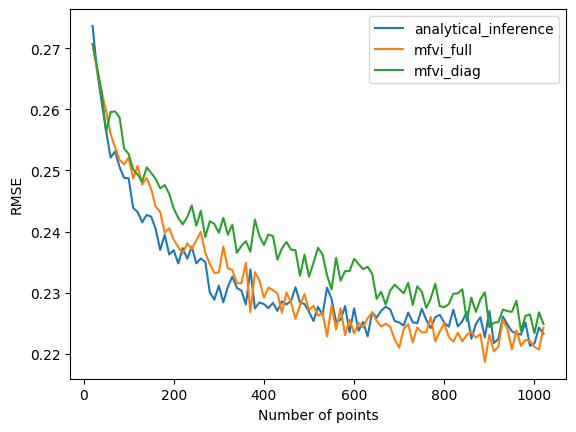

In [ ]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
for key in results_local_vi:
  plt.plot(steps, results_local_vi[key], label=key)
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_acq_plot.svg")

# Neural Processes

In [ ]:
# class NPModel(nn.Module):
#     def __init__(self, num_classes, moG=1):
#         super().__init__()
#         self.mog = moG

#         self.cnn = nn.Sequential(
#             nn.Conv2d(1, 32, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(32, 64, kernel_size=3, padding=1),
#             nn.ReLU(),
#             nn.MaxPool2d(2),

#             nn.Conv2d(64, 64, kernel_size=1),
#             nn.ReLU()
#         )

#         self.attn = nn.MultiheadAttention(
#             embed_dim=64,
#             num_heads=1,
#             dropout=0.1,
#             batch_first=True
#         )

#         self.norm = nn.LayerNorm(64)

#         self.mean_head = nn.Sequential(
#             nn.Linear(7 * 7 * 64, num_classes * moG),
#         )

#         self.logvar_head = nn.Sequential(
#             nn.Linear(7 * 7 * 64, num_classes * moG),
#         )

#         self.num_classes = num_classes

#     def forward(self, x):
#         if x.dim() == 4 and x.shape[-1] == 1:
#             x = x.permute(0, 3, 1, 2)

#         x = self.cnn(x)
#         x = x.flatten(2).transpose(1, 2)

#         attn_out, _ = self.attn(x, x, x)
#         x = self.norm(x + attn_out)

#         mean = self.mean_head(x.flatten(1)).reshape((-1, self.num_classes, self.mog))
#         logvar = self.logvar_head(x.flatten(1)).reshape((-1, self.num_classes, self.mog))
#         res = torch.stack([mean, logvar], dim=-1)

#         return res

class NPModel(nn.Module):
    def __init__(self, in_channels=1, outputs=10, mog=1):
        super().__init__()
        self.outputs = outputs
        self.mog = mog

        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels, 32, kernel_size=4),
            nn.ReLU(),
            nn.LayerNorm((25, 25)),
            nn.Conv2d(32, 32, kernel_size=4),
            nn.ReLU(),
            nn.Dropout(0.25),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(1936, 256),
            nn.ReLU()
        )

        self.out = nn.Linear(256, outputs * mog * 2)

    def forward(self, x):
        if x.dim() == 4 and x.shape[-1] == 1:
            x = x.permute(0, 3, 1, 2)
        batch_size = x.size(0)

        x = self.encoder(x)
        x = x.view(batch_size, -1)
        x = self.fc(x)

        x = self.out(x)
        x = x.view(batch_size, self.outputs, self.mog, 2)

        return x

In [ ]:
class NPInferenceModel(nn.Module):
  def __init__(self, np_model: NPModel):
    super().__init__()
    self.np_model = np_model

  def forward(self, z, **kwargs):
    mogs = self.np_model(z)
    eps = torch.normal(torch.zeros((z.shape[0], mogs.shape[1], mogs.shape[2])), torch.ones((z.shape[0], mogs.shape[1], mogs.shape[2]))).to(device=device)
    means = mogs[:, :, :, 0]
    log_vars = mogs[:, :, :, 1]
    # return torch.sum(means + torch.sqrt(torch.exp(log_vars)) * eps, dim=-1)
    return torch.mean(means, dim=-1)

In [ ]:
def np_acquisition_fn(T, model, x):
  model.eval()
  mog = model(x.to(device=device))
  return torch.sum(torch.sum(torch.exp(mog[:, :, :, 1]), dim=-1), dim=-1).detach()

In [ ]:
def call_batchwise_np_acq(model, x, batch_size=164):
  return torch.concat([np_acquisition_fn(1, model, x[i:i+batch_size]) for i in range(0, x.shape[0], batch_size)], dim=0)

In [ ]:
def evaluate_np(model, x, y, batch_size=164):
  y_hat = torch.concat([model(x[i:i+batch_size]) for i in range(0, x.shape[0], batch_size)], dim=0)
  return rmse_loss(y, y_hat).detach()

In [ ]:
def find_best_decay_np(x_train, y_train, x_val, y_val):
    weight_decays = [0, 1e-6, 5e-6, 1e-5, 1e-4]
    best_score = 0
    best_model_state = None
    best_i = 0
    train_dataset = torch.utils.data.TensorDataset(x_train, y_train)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True
    )

    for i, dec in enumerate(weight_decays):

        model = NPModel().to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=dec)
        criterion = nll_logvar
        total_loss = 0
        non_increasing = 0
        best_loss = None

        for epoch in range(150):
            model.train()
            for xb, yb in train_loader:
                xb = xb.to(device)
                yb = yb.to(device)
                optimizer.zero_grad()
                logits = model(xb)
                loss = criterion(yb.to(dtype=logits.dtype), logits)
                total_loss += loss.item()

                loss.backward()
                optimizer.step()
            if best_loss is None or total_loss < best_loss:
                non_increasing = 0
                best_loss = total_loss
            else:
                if non_increasing == 4:
                    break
                non_increasing += 1
            total_loss = 0

        inf_model = NPInferenceModel(model)
        val_acc = accuracy_classification(x_val, y_val, inf_model, device=device, batch_size=batch_size)
        val_acc = evaluate(x_val.to(device=device), y_val.to(device=device), rmse_loss, inf_model.to(device=device))
        

        if val_acc > best_score or i == 0:
            best_score = val_acc
            best_i = i
            best_model_state = model.state_dict()

        del model # save space if running locally
        gc.collect()
        if device == "mps":
            torch.mps.empty_cache()
        elif device == "cuda":
            torch.cuda.empty_cache()

    best_model = NPModel().to(device)
    best_model.load_state_dict(best_model_state)
    test_acc = evaluate(x_test.to(device=device), y_test.to(device=device), rmse_loss, NPInferenceModel(best_model).to(device=device))
    return best_model, test_acc

In [ ]:
import os
def train_once_local_opt_np(x_train_cur, y_train_cur, Xs, i):
  if os.path.exists(f"./model_artifacts/np_model_new_{i}.pt"):
    model_curr = NPModel()
    model_curr.load_state_dict(torch.load(f"./model_artifacts/np_model_new_{i}.pt", weights_only=True))
    model_curr.to(device=device)
    test_score = evaluate_np(NPInferenceModel(model_curr).to(device=device), x_test.to(device), y_test.to(device))
  else:
    model_curr, test_score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
    torch.save(model_curr.state_dict(), f"./model_artifacts/np_model_new_{i}.pt")
  acq_scores = call_batchwise_np_acq(model_curr, Xs, batch_size=512)
  x_new = acq_scores.topk(acquired_points).indices
  return test_score, x_new

In [ ]:
from tqdm import tqdm
def train_full_local_np(Xs, ys, x_init_train, y_init_train):
  scores = []
  x_train_cur = x_init_train.detach().clone()
  y_train_cur = y_init_train.detach().clone()
  for i in tqdm(range(acquisition_times)):
    score, x_new = train_once_local_opt_np(x_train_cur, y_train_cur, Xs, i)
    x_new_t = torch.tensor(x_new, dtype=torch.long)
    x_train_cur = torch.cat([x_train_cur, Xs[x_new_t.cpu()].to(device)], dim=0)
    y_train_cur = torch.cat([y_train_cur, ys[x_new_t.cpu()].to(device)], dim=0)
    mask = torch.ones(Xs.shape[0], dtype=torch.bool)
    mask[x_new_t.cpu()] = False
    Xs = Xs[mask]
    ys = ys[mask]
    scores.append(score)

  model, score = find_best_decay_np(x_train_cur, y_train_cur, x_val, y_val)
  scores.append(score)
  return torch.Tensor(scores), model

In [ ]:
def train_acquisition_np():
  os.makedirs("./model_artifacts", exist_ok=True)
  os.makedirs("./vi_results", exist_ok=True)
  scores = []
  for i in range(3):
    if os.path.exists(f"./vi_results/{i}np_local.npy"):
      score = np.load(f"./vi_results/{i}np_local.npy")
      score = torch.Tensor(score)
    else:
      score, model = train_full_local_np(X_p, y_p, x_train_new, y_train_new)
      np.save(f"./vi_results/{i}np_local.npy", score.detach().cpu().numpy())
      print(score)
    scores.append(score)    
  meaned_scores = torch.mean(torch.stack(scores), dim=0)

  return meaned_scores

In [ ]:
res = train_acquisition_np()
print(res)
np.save(f"./vi_results/np_results.npy", res.numpy())

tensor([0.5198, 0.5246, 0.4697, 0.4807, 0.4927, 0.4121, 0.5879, 0.5191, 0.5403,
        0.5372, 0.4737, 0.4963, 0.4102, 0.4672, 0.5014, 0.4729, 0.3760, 0.5094,
        0.4082, 0.4777, 0.4281, 0.3721, 0.5608, 0.4879, 0.5325, 0.4018, 0.4895,
        0.5835, 0.3675, 0.5661, 0.4235, 0.3512, 0.5959, 0.4024, 0.3580, 0.3458,
        0.5807, 0.4044, 0.5327, 0.3521, 0.3919, 0.3914, 0.2818, 0.3009, 0.2976,
        0.3881, 0.2560, 0.3167, 0.3309, 0.3956, 0.2844, 0.3449, 0.3463, 0.2525,
        0.2334, 0.2519, 0.2833, 0.2610, 0.2916, 0.2548, 0.2571, 0.2651, 0.2722,
        0.2794, 0.2609, 0.2524, 0.2214, 0.2466, 0.2166, 0.2154, 0.2173, 0.2284,
        0.2698, 0.2160, 0.2392, 0.2361, 0.2143, 0.2371, 0.2268, 0.2372, 0.2409,
        0.2102, 0.2279, 0.1984, 0.2411, 0.2287, 0.1998, 0.1998, 0.2531, 0.2757,
        0.1933, 0.2067, 0.1780, 0.2187, 0.2020, 0.1935, 0.1947, 0.2795, 0.1816,
        0.1724, 0.1976])


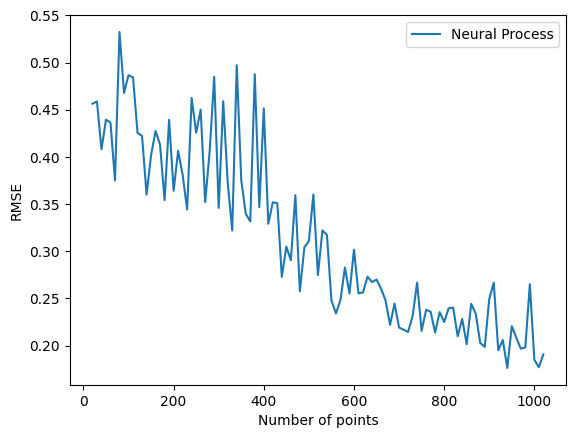

In [ ]:
res = np.load('./vi_results/np_results.npy')
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, res, label="Neural Process")
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_results/np_acq_plot.svg")

# Compare individual to constant variance

In [81]:
class HierarchicalRegressorEnergy(nn.Module):
    def __init__(self, input_dim=10, hidden_dim=128, output_dim=3):
        super().__init__()

        self.conv = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),

            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )
        self.last = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.conv(x)
        return self.last(x)

In [88]:
x_train_new, y_train_new, X_p, y_p, x_val, y_val, x_test, y_test = load_uci(val_size=1000)
device = torch.device("mps") if torch.mps.is_available() else "cpu"
device = torch.device("cuda") if torch.cuda.is_available() else device
x_train_new = x_train_new.to(dtype=torch.float32).to(device)
y_train_new = y_train_new.to(dtype=torch.float32).to(device)
X_p = X_p.to(dtype=torch.float32)
y_p = y_p.to(dtype=torch.float32)
x_val = x_val.to(device)
y_val = y_val.to(device)
x_test = x_test.to(device)
y_test = y_test.to(device)
batch_size = 128
epochs = 70
acquired_points = 10
num_classes = 3
acquisition_times = 100
data_variances = [0.1, 0.25, 0.5, 6, 8, 10, 16]

In [89]:
def compute_individual():
  scores = []
  for i in range(3):
    score, model = train_full_local_pv("analytical_inference", X_p, y_p, x_train_new, y_train_new, None, True, HierarchicalRegressorEnergy)
    np.save(f"./vi_results/{i}ai_individual.npy", score.detach().cpu().numpy())
    print(score.detach())
    scores.append(score)
  meaned_scores = torch.mean(torch.stack(scores), dim=0)
  return meaned_scores

def compute_constant():
  scores = []
  for i in range(3):
    score, model = train_full_local_pv("analytical_inference", X_p, y_p, x_train_new, y_train_new, None, False, HierarchicalRegressorEnergy)
    np.save(f"./vi_results/{i}ai_constant.npy", score.detach().cpu().numpy())
    print(score.detach())
    scores.append(score)
  meaned_scores = torch.mean(torch.stack(scores), dim=0)
  return meaned_scores

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


tensor([654.1666, 652.3785, 651.4294, 650.7467, 651.8125, 651.0200, 648.6870,
        649.1030, 644.6254, 644.3862, 646.8022, 643.3165, 642.2418, 637.7858,
        640.3809, 642.0247, 642.5718, 635.5064, 639.7265, 634.8918, 631.1196,
        634.4370, 635.4552, 634.5859, 630.2783, 627.2009, 627.6273, 626.3233,
        626.9534, 628.2477, 624.2451, 621.5952, 616.1547, 623.2917, 624.7693,
        625.2489, 617.1169, 617.0183, 608.6213, 603.9596, 604.0397, 605.3222,
        609.1970, 599.9998, 603.7660, 590.6407, 594.4900, 601.5066, 593.7140,
        589.2838, 582.8507, 580.7101, 600.2930, 588.5045, 560.1388, 581.8918,
        605.4291, 599.4926, 585.2160, 570.3473, 556.1407, 558.6730, 570.6525,
        595.6726, 586.8711, 548.4958, 586.9613, 570.9250, 580.6030, 576.4453,
        565.2032, 571.1241, 548.6206, 551.7126, 569.2290, 536.3445, 511.4772,
        515.6503, 498.7576, 536.9434, 547.0066, 517.5224, 523.0919, 539.3531,
        472.3490, 520.0618, 525.6876, 563.0051, 497.2491, 522.31

100%|██████████| 100/100 [04:02<00:00,  2.42s/it]


tensor([653.9012, 652.3412, 652.2135, 650.7273, 650.1185, 647.7209, 646.5985,
        647.8528, 646.5146, 645.3041, 645.0043, 643.7692, 641.9182, 639.0283,
        639.9935, 643.3510, 635.3962, 635.9671, 638.0103, 636.9486, 626.1733,
        632.7637, 630.1097, 634.1345, 628.0248, 627.3422, 627.1525, 626.5165,
        621.6841, 617.6184, 624.1477, 621.8862, 613.3361, 622.3099, 614.9756,
        628.9022, 612.8982, 613.0734, 617.0574, 601.4333, 608.5259, 609.4219,
        608.5720, 600.3666, 604.8129, 612.5325, 625.3234, 599.3698, 593.7240,
        609.5194, 594.4056, 584.2329, 586.5941, 600.2892, 580.3024, 579.8587,
        596.3133, 566.0888, 590.0960, 572.5175, 579.3401, 575.1655, 575.4097,
        578.7682, 569.0381, 585.8499, 559.2278, 547.7867, 579.3492, 569.4816,
        581.5343, 567.9579, 576.6710, 543.6915, 559.5811, 525.2448, 527.3662,
        527.2463, 527.8069, 543.4031, 510.4494, 537.4638, 573.3453, 492.7971,
        558.3834, 507.2694, 504.4610, 524.8278, 535.5771, 518.41

100%|██████████| 100/100 [03:56<00:00,  2.37s/it]


tensor([653.8220, 653.2640, 652.7090, 651.9240, 650.4875, 648.6196, 649.6250,
        647.4958, 646.6457, 645.1935, 644.4342, 639.9008, 639.5117, 641.4292,
        642.0716, 640.5143, 638.7287, 638.1982, 640.4504, 636.8295, 638.0022,
        633.2715, 634.4621, 630.1765, 627.9866, 619.1133, 626.4410, 631.2587,
        625.8173, 621.0892, 623.0685, 621.7013, 618.5112, 619.1662, 621.8971,
        618.4941, 619.0009, 604.0123, 623.4990, 608.1050, 600.0139, 612.1915,
        615.9120, 598.7262, 596.3282, 600.5939, 598.0319, 608.0822, 610.3051,
        613.2697, 597.0474, 588.2934, 583.7487, 600.1540, 590.1939, 569.6536,
        586.9065, 597.9449, 568.9125, 566.6951, 603.1769, 576.4823, 593.2531,
        582.3935, 551.4861, 549.9784, 535.4019, 546.8235, 568.8911, 563.7134,
        545.7689, 515.1014, 558.0772, 572.0557, 550.6420, 525.9597, 539.3333,
        548.9676, 548.9825, 553.8384, 530.3284, 553.5790, 480.7632, 549.5732,
        538.8395, 526.1320, 515.9478, 536.0494, 521.5084, 526.55

100%|██████████| 100/100 [13:53<00:00,  8.34s/it]


tensor([650.6855, 653.2703, 652.2722, 651.4437, 650.9465, 650.0245, 649.9683,
        648.2587, 646.7188, 646.4131, 643.9078, 644.6232, 643.9482, 638.1847,
        639.8441, 637.9130, 641.4412, 636.0500, 638.7221, 635.9178, 633.6231,
        631.9728, 632.9591, 631.8919, 627.6357, 635.8707, 622.4144, 631.2781,
        627.8119, 611.4816, 632.1042, 607.6970, 626.5021, 616.3640, 609.2817,
        622.1032, 615.5884, 623.1770, 603.0245, 607.5074, 616.0168, 608.6285,
        604.0546, 613.6826, 591.0301, 594.5858, 594.9788, 608.4656, 600.2717,
        577.9350, 594.2446, 596.3071, 587.4585, 589.1503, 580.3238, 557.9818,
        581.9617, 603.5894, 588.3222, 579.0475, 592.5699, 550.0982, 573.6581,
        517.6286, 590.7782, 558.5132, 566.3844, 554.5936, 574.2252, 570.8329,
        561.7993, 537.5660, 573.2267, 544.4518, 533.2238, 507.6614, 508.8226,
        569.3074, 553.7181, 526.3278, 552.3875, 515.7503, 531.5840, 494.5681,
        521.1138, 521.5684, 557.6927, 523.3890, 522.2061, 501.92

100%|██████████| 100/100 [14:25<00:00,  8.65s/it]


tensor([654.2955, 652.4481, 652.2145, 651.9670, 649.9528, 650.0100, 649.3561,
        647.7622, 646.3788, 641.9021, 643.9877, 640.3973, 640.2849, 646.3654,
        642.6805, 637.2410, 639.8532, 636.5566, 635.1888, 634.9782, 631.2988,
        634.2145, 636.9339, 640.4340, 627.6513, 633.8214, 622.1220, 633.1174,
        624.0416, 624.9932, 627.6793, 616.2037, 621.9796, 621.7126, 613.6307,
        624.6058, 630.2125, 624.5557, 612.9488, 606.1628, 607.2864, 605.6406,
        604.6518, 610.5597, 596.4650, 598.1001, 603.9759, 598.8244, 595.9297,
        595.7376, 604.8644, 604.3909, 594.2693, 571.1138, 589.0848, 587.7859,
        566.9636, 579.1485, 585.9456, 593.7480, 571.2766, 583.8383, 574.0815,
        561.5765, 589.9277, 541.4879, 564.3873, 586.5464, 582.7697, 553.4496,
        545.9921, 576.4724, 561.7149, 554.8834, 519.7452, 558.3143, 534.7160,
        527.4126, 569.5847, 542.6733, 505.6477, 535.8866, 553.5122, 545.5137,
        513.6448, 536.7716, 528.4164, 545.3996, 528.7730, 540.44

100%|██████████| 100/100 [13:36<00:00,  8.16s/it]


tensor([653.9942, 652.0867, 651.9354, 650.8619, 651.3044, 649.8834, 629.0763,
        649.1327, 648.7258, 646.1221, 644.5836, 641.8748, 642.9291, 641.6804,
        643.3447, 641.3994, 637.5119, 639.6251, 636.9012, 639.5963, 630.9695,
        632.8035, 632.4193, 633.3065, 629.9144, 628.3589, 626.9305, 630.3284,
        622.8499, 625.7159, 627.8922, 625.3676, 626.7498, 620.5019, 616.7733,
        616.9627, 611.5819, 608.2332, 599.2625, 606.6552, 618.9064, 605.2024,
        607.5540, 598.8833, 606.7515, 616.7852, 603.3389, 592.8644, 595.5214,
        609.1607, 579.1791, 591.4468, 598.2416, 598.9125, 594.3388, 589.0784,
        590.2590, 567.9851, 589.5907, 588.3206, 577.6587, 599.7039, 559.5033,
        585.2785, 570.9828, 514.5221, 558.6740, 566.7723, 527.3803, 574.5607,
        571.4409, 557.3547, 531.9852, 570.7819, 541.7296, 543.9836, 560.5575,
        525.5560, 524.2310, 553.5489, 514.5231, 525.1598, 526.1136, 516.2228,
        544.4167, 532.3170, 558.1187, 535.4239, 489.3561, 565.60

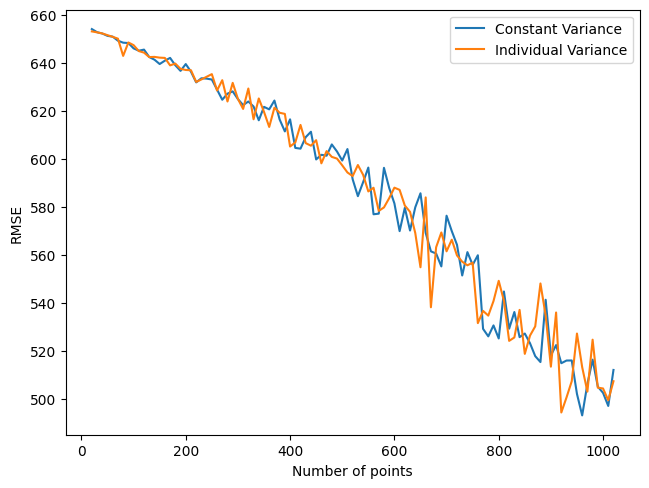

In [90]:
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, compute_constant(), label="Constant Variance")
plt.plot(steps, compute_individual(), label="Individual Variance")
plt.tight_layout()
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.legend()
plt.savefig("./vi_individual_acq_plot.svg")

# RMSE compare plots

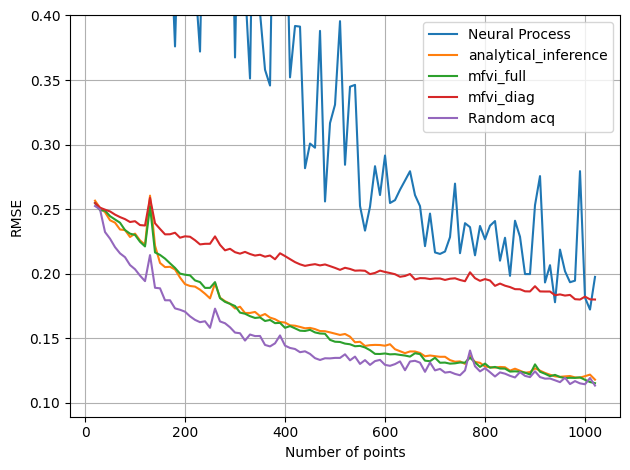

In [87]:
res_np = np.load('./vi_results/np_results.npy')
steps = list(range(20, 20 + acquired_points * acquisition_times + 1, acquired_points))
plt.plot(steps, res_np, label="Neural Process")
for key in vi_acq_functions:
  res = np.load(f"./{str(key)}_local.npy")
  plt.plot(steps, res, label=key)
res_rand = np.load("./results/random_rmse.npy")
plt.plot(steps, res_rand, label="Random acq")
plt.xlabel("Number of points")
plt.ylabel("RMSE")
plt.ylim(top=0.4)
plt.grid()
plt.tight_layout()
plt.legend()
plt.savefig("./vi_results/all_rmse_plots.svg")